In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
from scipy import integrate,special

In [2]:
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 8
z_max = 0.020/x0
z_start = 0.020/x0
dz = 0.0005/x0
dv = 0.0005
v_eval = np.arange(1.0,4.0,0.5)
t_eval = np.linspace(0.,3000000.,3000001)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*(0.012)**2)/Isat
power_index = 2

#Make the axis:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)



H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

[[ 0.          0.          0.          0.02132779  0.          0.
   0.0600504   0.          0.          0.          0.          0.        ]
 [-0.02132779  0.         -0.02113426  0.          0.          0.0300252
   0.          0.          0.          0.0300252   0.          0.        ]
 [ 0.          0.          0.         -0.02113426 -0.         -0.
   0.0300252   0.          0.          0.          0.05200518  0.        ]
 [-0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.07354642]
 [-0.0600504   0.          0.0300252   0.          0.          0.05302918
   0.          0.          0.         -0.01056713  0.          0.        ]
 [ 0.          0.          0.          0.0300252   0.          0.
   0.05302918  0.          0.          0.         -0.0183028   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.02588407

In [3]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -1
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [29]:
def vc_bayesian(v0s,I, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(I,R:np.array):
        n = 510
        s = 0.1016 # in meter
        rad = 0.071976 # in meter
        def dBx(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            # print(dl,rprime,dB)
            return dB[0]
        def dBy(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[1]

        def dBz(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[2]


        Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
        By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
        Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]

        return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    
#     def trap_condition(t,y):
#         if abs(y[-6])*1000*x0<10 and abs(y[-4])*1000*x0<10 and abs(y[-3])<5e-2 and abs(y[-1])<5e-2:
#             val = -1.
#         else:
#             val = 1.
#         return val
    
#     def lost_condition(t,y):
#         if y[-6]*1000*x0>30 or abs(y[-4])*1000*x0>10:
#             val = -1.
#         else:
#             val=1.
#         return val
    
#     trap_condition.terminal = True
#     lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = lambda R,t : Coil_field(I,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    if abs(sol.r[0][-1])*1000*x0<10 and abs(sol.v[0][-1])<5e-2:
        return v0s
    else:
        return -1.

In [30]:
start = time.time()

print(vc_bayesian(2.5,3.5,-0.4,0.1,-1.7,-2.8,5,21,28,26,-1,-1,1,-1))  

print(time.time()-start)

-1.0
450.74100065231323


In [31]:
pbounds = {'v0s':(2,8),'I':(1,20),'d1':(-3,1),'d2':(-3,1),'d3':(-3,1),'d4':(-3,1),'p1':(0,50),'p2':(0,50),'p3':(0,50),'p4':(0,50),'pol1':(-1,1),'pol2':(-1,1),'pol3':(-1,1),'pol4':(-1,1)}

In [32]:
optimizer = BayesianOptimization(
    f = vc_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [33]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |     I     |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.0      |  8.923    | -0.1187   | -3.0      | -1.791    | -2.413    |  4.617    |  9.313    |  17.28    |  19.84    |  0.07763  | -0.1616   |  0.3704   | -0.5911   |  7.269    |
|  2        | -1.0      |  8.462    | -0.5539   | -0.8439   | -2.181    | -2.332    |  24.15    |  28.56    |  2.302    |  30.67    | -0.5294   | -0.2846   |  0.7505   |  0.5304   |  2.657    |
986.110374212265


In [34]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
# load_logs(optimizer, logs=["./logs.json"])

In [35]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_coil.json',reset=True)
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [36]:
start = time.time()
optimizer.maximize(
    init_points=30,
    n_iter=100,)
print(time.time()-start)

|   iter    |  target   |     I     |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  3        |  2.234    |  1.52     | -0.3181   | -1.331    | -0.7652   | -2.438    |  9.905    |  40.04    |  48.41    |  15.67    |  0.3846   |  0.7528   |  0.7892   | -0.8299   |  2.234    |
|  4        | -1.0      |  4.227    |  0.5126   | -2.607    | -1.316    |  0.8316   |  26.66    |  34.59    |  15.78    |  34.33    |  0.6693   | -0.9634   |  0.5003   |  0.9777   |  6.489    |
|  5        | -1.0      |  6.328    |  0.1571   | -2.587    | -1.208    |  0.6344   |  14.68    |  14.39    |  6.501    |  0.9683   |  0.3577   | -0.5767   | -0.4689   | -0.01685  |  2.32     |
|  6        | -1.0      |  11.

KeyboardInterrupt: 

In [22]:
import pprint

In [23]:
pprint.pprint(optimizer.max)

{'params': {'I': 8.03650871631438,
            'd1': -3.0,
            'd2': -1.0778610033113942,
            'd3': -0.1464607184316592,
            'd4': -2.6841050063263534,
            'p1': 30.536163924358625,
            'p2': 28.531208249923036,
            'p3': 28.328942174261456,
            'p4': 50.0,
            'pol1': 0.871330043345536,
            'pol2': -1.0,
            'pol3': 0.11854163735823,
            'pol4': 0.08600194628618438,
            'v0s': 8.0},
 'target': 8.0}


In [14]:
optimizer.res[0]

{'target': 7.268704618345673,
 'params': {'I': 8.923418089348907,
  'd1': -0.11870202623136761,
  'd2': -2.9995425007306205,
  'd3': -1.790669709472641,
  'd4': -2.412976436731548,
  'p1': 4.6169297384398895,
  'p2': 9.313010568883545,
  'p3': 17.278036352152387,
  'p4': 19.838373711533496,
  'pol1': 0.07763346800671389,
  'pol2': -0.1616109711934104,
  'pol3': 0.370439000793519,
  'pol4': -0.5910955005369651,
  'v0s': 7.268704618345673}}

In [15]:
# vc_bayesian(**optimizer.max['params'])

In [24]:
def ploting_function(v0s,I, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(I,R:np.array):
        n = 510
        s = 0.1016 # in meter
        rad = 0.071976 # in meter
        def dBx(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            # print(dl,rprime,dB)
            return dB[0]
        def dBy(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[1]

        def dBz(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[2]


        Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
        By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
        Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]

        return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=lambda R,t:Coil_field(I,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,0,0]),np.array([v0s,0,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    
    fig,ax = plt.subplots(1,1,figsize=(13,7))
    
    imz = ax.imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax)
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$v (\mathrm{m/s})$')
    ax.set_title('X axis force image')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    ax.plot(eqn.sol.r[0]*x0*1000,eqn.sol.v[0]*v0,'k') 
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/optimized')
    

In [25]:
def ploting_function_2(v0s,I, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def Coil_field(I,R:np.array):
        n = 510
        s = 0.1016 # in meter
        rad = 0.071976 # in meter
        def dBx(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            # print(dl,rprime,dB)
            return dB[0]
        def dBy(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[1]

        def dBz(theta,L):
            dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
            rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
            dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
            return dB[2]


        Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
        By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
        Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]

        return np.array([Bx,By,Bz])*n*10000 # Return in Gauss
    v_list = np.linspace(v0s-2,v0s+2,11)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=lambda R,t:Coil_field(I,R)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)


    
    for v0ss in v_list:
        eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0ss,v0ss,1]))
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 1,method='LSODA')
        sols_list.append(eqn.sol)
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    for sol in sols_list:
        ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0)
        ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0)
        ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0)
        print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
#     fig.savefig('./MOT/optimized_xy')
    

Completed in 4:51.                                                  
Completed in 4:56.                                                  
Completed in 5:00.                                                  
Completed in 5:23.                                                       
Completed in 2:36.                                                       
Completed in 1:05.                                                       
Completed in 1:24.                                                       
Completed in 1:44.                                                       
Completed in 1:38.                                                       
Completed in 2:00.                                                       
Completed in 1:38.                                                       
Completed in 1:52.                                                       
Completed in 1:45.                                                       
Completed in 2:03.                                   

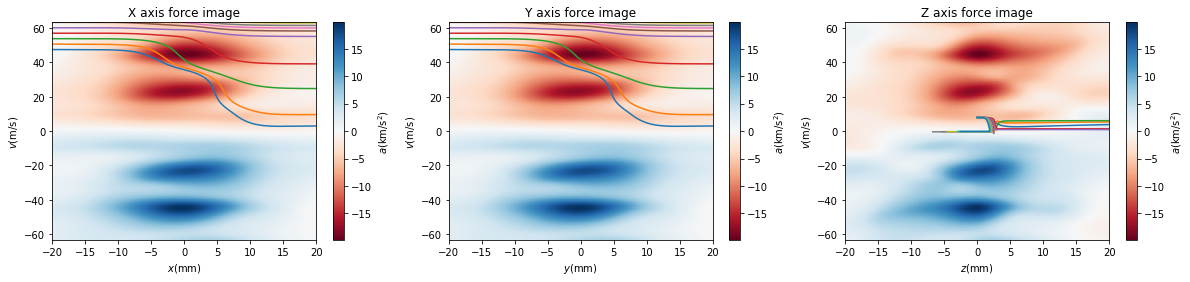

In [26]:
ploting_function_2(**optimizer.max['params'])

In [19]:
optimizer.max['params']

{'I': 8.03650871631438,
 'd1': -3.0,
 'd2': -1.0778610033113942,
 'd3': -0.1464607184316592,
 'd4': -2.6841050063263534,
 'p1': 30.536163924358625,
 'p2': 28.531208249923036,
 'p3': 28.328942174261456,
 'p4': 50.0,
 'pol1': 0.871330043345536,
 'pol2': -1.0,
 'pol3': 0.11854163735823,
 'pol4': 0.08600194628618438,
 'v0s': 8.0}

In [20]:
3e6*t0

0.02170294678525846

In [21]:
1e5*x0

0.0057184371052918